# Project: Decoding Molecules From Fingerprints.
## Group Members:
### Qi Chen, e-mail: gusqichr@student.gu.se
### Nils Dunlop, e-mail: gusdunlni@student.gu.se
### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
***

In [2]:
import zipfile
import os
import pandas as pd
import numpy as np
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import PandasTools
from IPython.display import display
from joblib import Parallel, delayed
from rdkit import Chem
import subprocess
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem
from rdkit import DataStructs
import py3Dmol

### Exploratory Analysis
***

In [8]:
# Path to the data
zip_file_path = '../data/final_chembl.zip'

with zipfile.ZipFile(zip_file_path, 'r') as z:
    file_list = z.namelist()

    csv_filename = file_list[0]

    # Read the file as a pandas DataFrame
    with z.open(csv_filename) as f:
        df = pd.read_csv(f)

df.head()

ChEMBL ID                                             smiles  \
0  CHEMBL3897759  Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5ccc(F)c(F)c5)C...   
1  CHEMBL3935110  Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5cc(F)ccc5F)CC4...   
2  CHEMBL3347413    N#Cc1cc(Cl)cc(Oc2cc(CCc3cccnc3)[nH]c(=O)c2Cl)c1   
3  CHEMBL1739263  N=C(N)c1ccc(-c2sc(-c3ccc(C(=N)N)cc3)c3c2OCCO3)cc1   
4  CHEMBL3917493  O=C(C=Cc1cccs1)c1cccc(NC(=O)c2cc(-c3ccncc3)[nH...   

   MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0       13.506757       -0.836612          13.506757           0.011403   
1       13.986498       -0.441178          13.986498           0.012570   
2       12.093976       -0.437141          12.093976           0.061471   
3        7.537508        0.042215           7.537508           0.042215   
4       12.517530       -0.360849          12.517530           0.130332   

        qed    MolWt  HeavyAtomMolWt  ExactMolWt  ...  fr_tetrazole  \
0  0.294586  544.650         510.378  544.276216  ...             0   
1  0.294586  544.650         510.378  544.276216  ...             0   
2  0.699111  386.238         373.134  385.038482  ...             0   
3  0.410744  378.457         360.313  378.115047  ...             0   
4  0.363273  400.463         384.335  400.099397  ...             0   

   fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  \
0            0            0             0                 0        0   
1            0            0             0                 0        0   
2            0            0             0                 0        0   
3            0            0             1                 0        0   
4            0            0             1                 0        0   

   NumBridgeheadAtoms  LongestAliChain  LargestRing  MolLogLike  
0                   0                1            6  -12.275704  
1                   0                1            6  -12.228626  
2                   0                2            6  -11.894518  
3                   0                0            6  -12.655379  
4                   0                0            6  -11.901545  

[5 rows x 214 columns]

In [9]:
print(len(df))

1382680


In [10]:
# Sub Dataframe of ChEMBL ID and SMILES
smiles_df = df[['ChEMBL ID', 'smiles']].copy()

PandasTools.AddMoleculeColumnToFrame(smiles_df, 'smiles', 'Molecule')

display(smiles_df.head())

ChEMBL ID                                             smiles  \
0  CHEMBL3897759  Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5ccc(F)c(F)c5)C...   
1  CHEMBL3935110  Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5cc(F)ccc5F)CC4...   
2  CHEMBL3347413    N#Cc1cc(Cl)cc(Oc2cc(CCc3cccnc3)[nH]c(=O)c2Cl)c1   
3  CHEMBL1739263  N=C(N)c1ccc(-c2sc(-c3ccc(C(=N)N)cc3)c3c2OCCO3)cc1   
4  CHEMBL3917493  O=C(C=Cc1cccs1)c1cccc(NC(=O)c2cc(-c3ccncc3)[nH...   

                                        Molecule  
0  <rdkit.Chem.rdchem.Mol object at 0x148521770>  
1  <rdkit.Chem.rdchem.Mol object at 0x1485202e0>  
2  <rdkit.Chem.rdchem.Mol object at 0x148521700>  
3  <rdkit.Chem.rdchem.Mol object at 0x1485205f0>  
4  <rdkit.Chem.rdchem.Mol object at 0x148520e40>

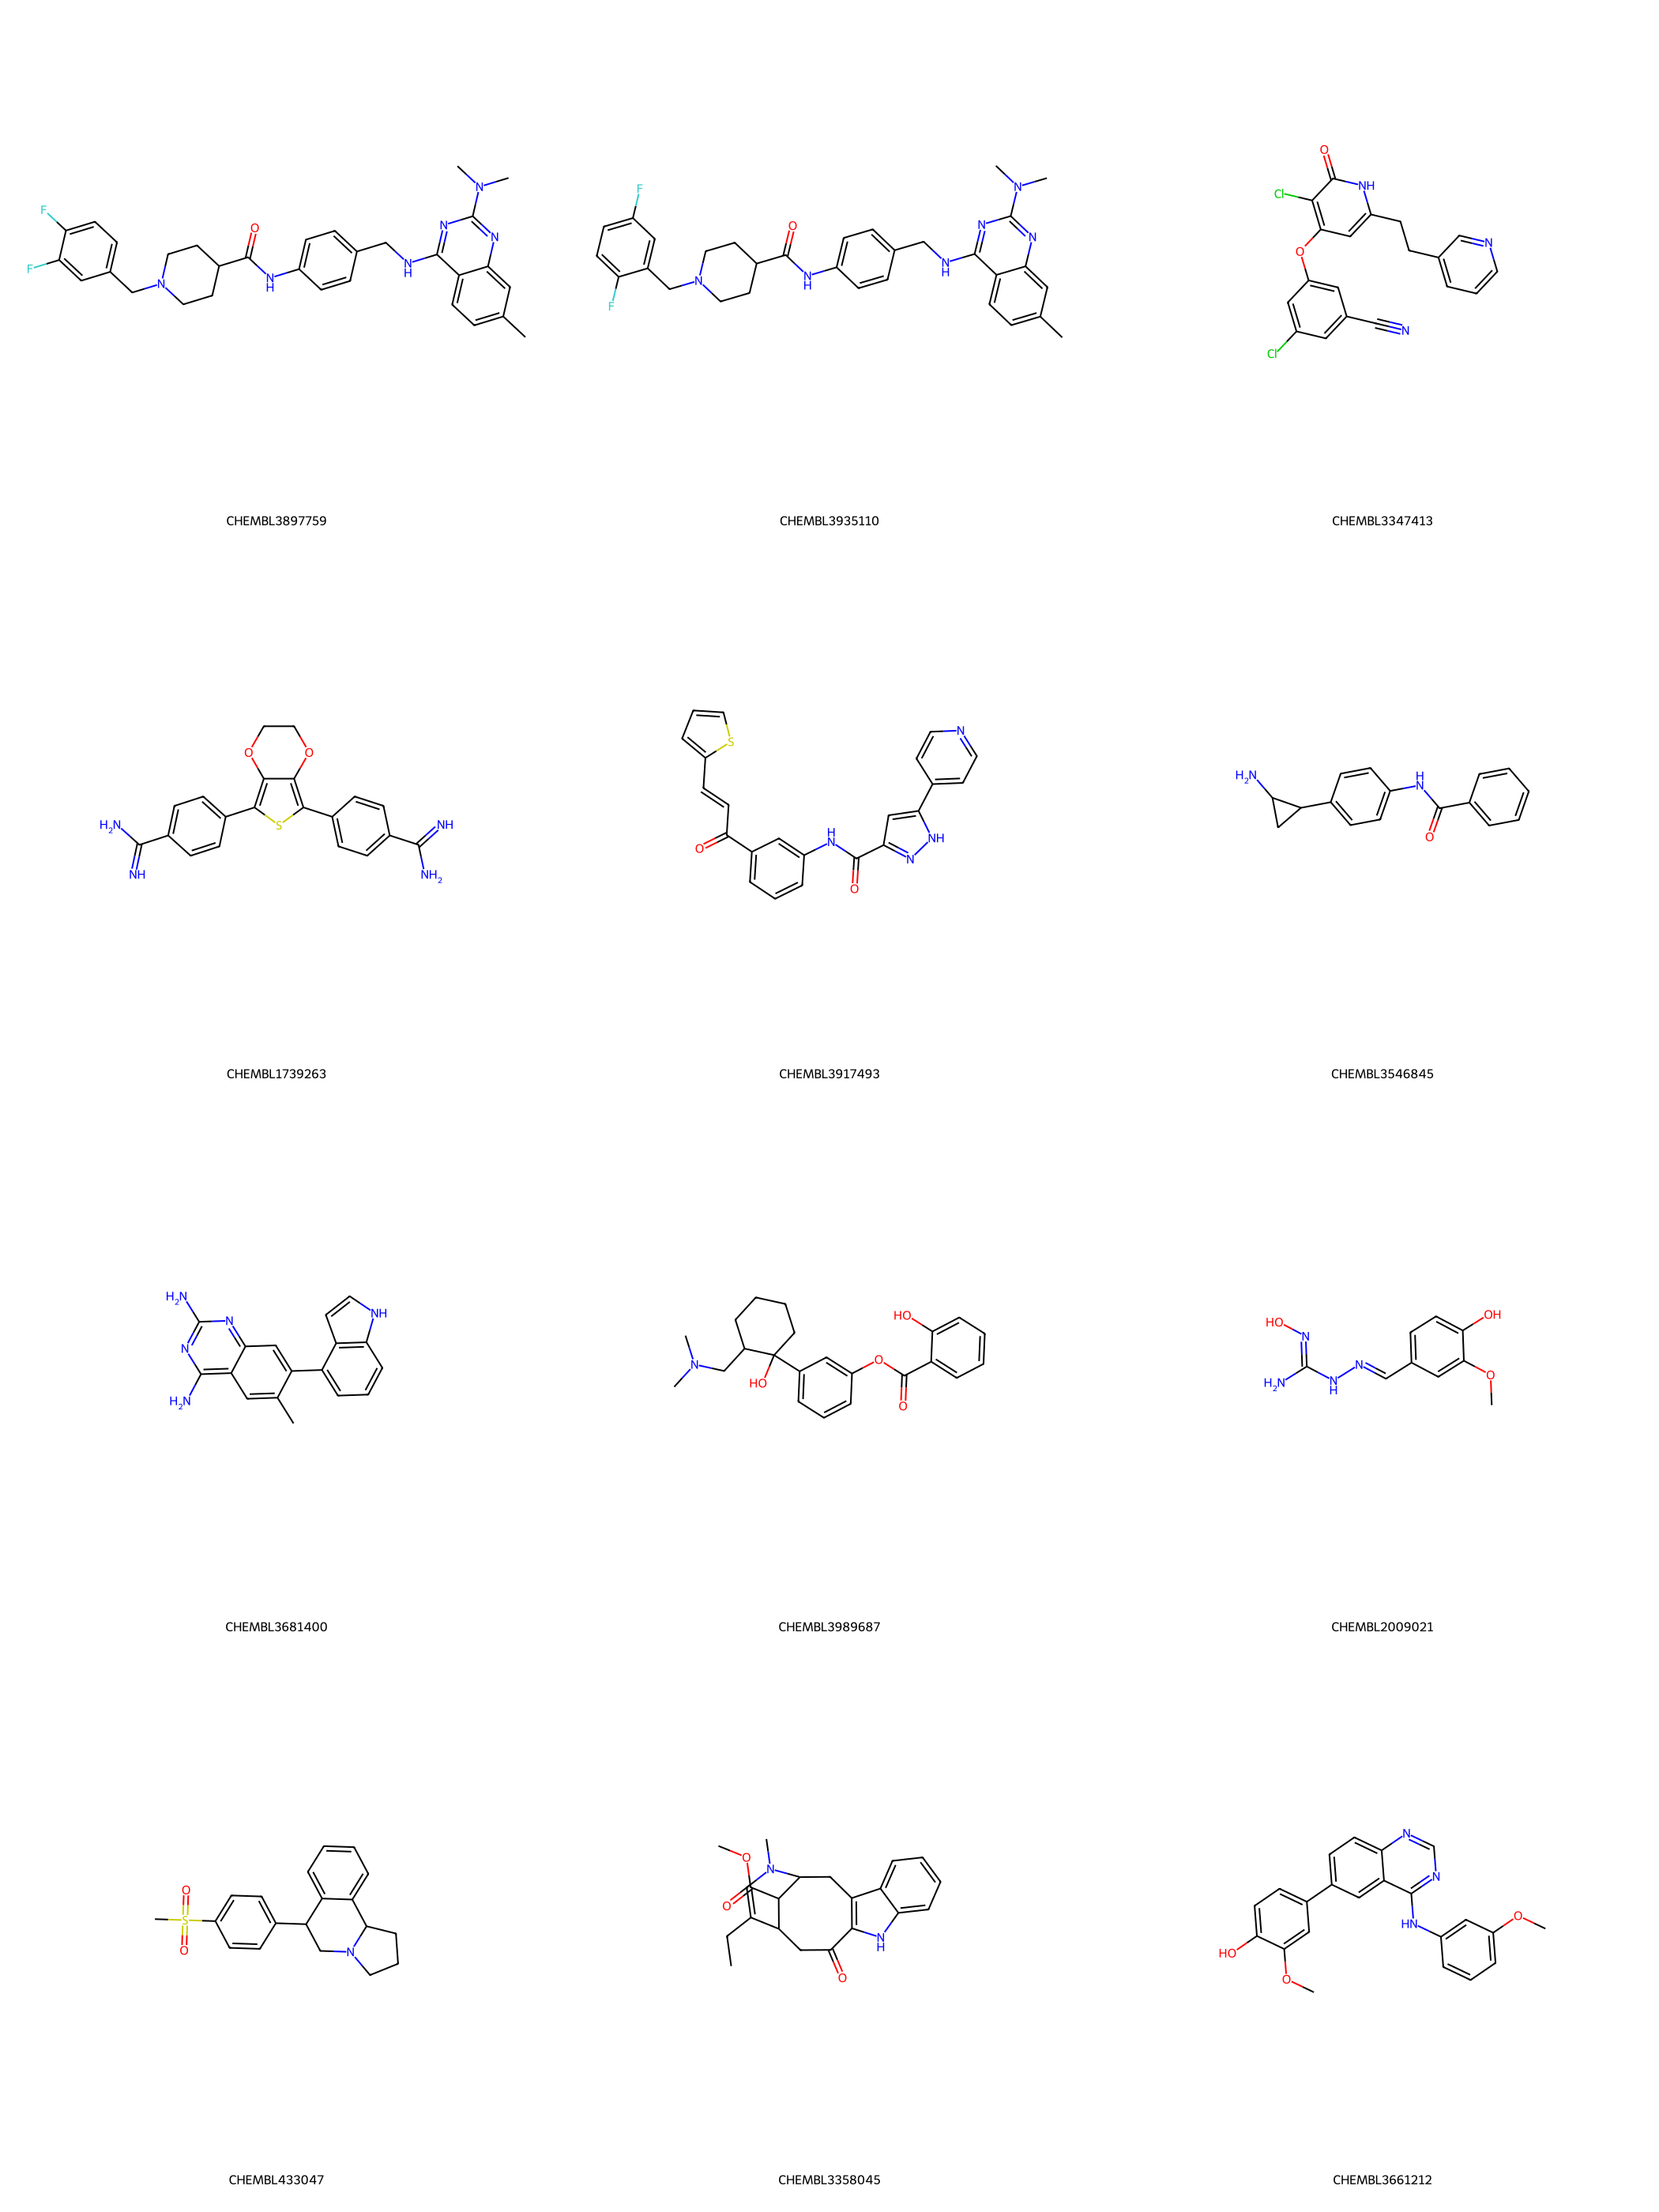

In [11]:
# Prepare molecules and ChEMBL IDs for display (limit to first 10)
mols = smiles_df['Molecule'].tolist()[:12]
ids = smiles_df['ChEMBL ID'].tolist()[:12]

# Display the grid of molecules
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(700, 700), legends=ids)
display(img)

#### Convert SMILES to Fingerprints
***

In [5]:
# Function to generate ECFP4 fingerprint and sparse representation
def generate_fingerprint(mol):
    if mol is not None:
        # Create the Morgan fingerprint generator
        morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
        fp = morgan_generator.GetFingerprint(mol)

        # Convert to a bit vector
        bit_vector = np.array(list(fp.ToBitString())).astype(int)

        # Get sparse representation: indices of '1' bits
        sparse_representation = list(np.where(bit_vector == 1)[0])

        # Convert sparse representation to a string of space-separated indices
        sparse_representation_str = ' '.join(map(str, sparse_representation))
        
        return bit_vector, sparse_representation_str
    return None, None

# Parallel processing for fingerprint generation
num_cores = -1
results = Parallel(n_jobs=num_cores)(delayed(generate_fingerprint)(mol) for mol in smiles_df['Molecule'])

# Unzip the results into two lists
bit_vectors, sparse_fingerprints = zip(*results)

# Assign the new columns to the DataFrame
smiles_df['FingerprintBits'] = list(bit_vectors)
smiles_df['SparseFingerprintBits'] = list(sparse_fingerprints)

# Display the DataFrame with FingerprintBits and SparseFingerprintBits
smiles_df.head()

ChEMBL ID                                             smiles  \
0  CHEMBL3897759  Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5ccc(F)c(F)c5)C...   
1  CHEMBL3935110  Cc1ccc2c(NCc3ccc(NC(=O)C4CCN(Cc5cc(F)ccc5F)CC4...   
2  CHEMBL3347413    N#Cc1cc(Cl)cc(Oc2cc(CCc3cccnc3)[nH]c(=O)c2Cl)c1   
3  CHEMBL1739263  N=C(N)c1ccc(-c2sc(-c3ccc(C(=N)N)cc3)c3c2OCCO3)cc1   
4  CHEMBL3917493  O=C(C=Cc1cccs1)c1cccc(NC(=O)c2cc(-c3ccncc3)[nH...   

                                            Molecule  \
0  <rdkit.Chem.rdchem.Mol object at 0x0000017440A...   
1  <rdkit.Chem.rdchem.Mol object at 0x0000017440A...   
2  <rdkit.Chem.rdchem.Mol object at 0x0000017440A...   
3  <rdkit.Chem.rdchem.Mol object at 0x0000017440A...   
4  <rdkit.Chem.rdchem.Mol object at 0x0000017440A...   

                                     FingerprintBits  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...   

                               SparseFingerprintBits  
0  80 191 216 235 255 263 310 363 378 380 467 531...  
1  80 191 216 235 249 255 263 310 363 378 380 467...  
2  24 80 102 216 240 301 305 314 322 378 437 499 ...  
3  82 140 162 338 441 621 623 656 675 807 854 876...  
4  12 14 31 63 74 119 184 191 241 378 383 391 486...

#### Save Fingerprints to a Parquet File
***

In [6]:
# Drop the 'Molecule' column and save the rest of the DataFrame
smiles_df_filtered = smiles_df.drop(columns=['Molecule'])

# Write the DataFrame in smaller chunks, saving separate files
chunk_size = 10000  # Adjust based on your system's memory
num_chunks = len(smiles_df_filtered) // chunk_size + 1

for i in range(num_chunks):
    start_row = i * chunk_size
    end_row = (i + 1) * chunk_size
    chunk_df = smiles_df_filtered.iloc[start_row:end_row]
    
    # Save each chunk to a separate Parquet file
    file_name = f'molecule_fingerprints_part_{i}.parquet'
    chunk_df.to_parquet(file_name, compression='snappy')

    print(f"Saved chunk {i+1}/{num_chunks} to {file_name}")

Saved chunk 1/139 to molecule_fingerprints_part_0.parquet
Saved chunk 2/139 to molecule_fingerprints_part_1.parquet
Saved chunk 3/139 to molecule_fingerprints_part_2.parquet
Saved chunk 4/139 to molecule_fingerprints_part_3.parquet
Saved chunk 5/139 to molecule_fingerprints_part_4.parquet
Saved chunk 6/139 to molecule_fingerprints_part_5.parquet
Saved chunk 7/139 to molecule_fingerprints_part_6.parquet
Saved chunk 8/139 to molecule_fingerprints_part_7.parquet
Saved chunk 9/139 to molecule_fingerprints_part_8.parquet
Saved chunk 10/139 to molecule_fingerprints_part_9.parquet
Saved chunk 11/139 to molecule_fingerprints_part_10.parquet
Saved chunk 12/139 to molecule_fingerprints_part_11.parquet
Saved chunk 13/139 to molecule_fingerprints_part_12.parquet
Saved chunk 14/139 to molecule_fingerprints_part_13.parquet
Saved chunk 15/139 to molecule_fingerprints_part_14.parquet
Saved chunk 16/139 to molecule_fingerprints_part_15.parquet
Saved chunk 17/139 to molecule_fingerprints_part_16.parquet

In [11]:
# Set the output file path
output_file = 'molecule_fingerprints_combined.parquet'

# Remove the output file if it already exists
if os.path.exists(output_file):
    os.remove(output_file)

# List of chunk files
file_names = [f'molecule_fingerprints_part_{i}.parquet' for i in range(num_chunks)]

# Initialize an empty DataFrame to accumulate chunks
combined_df = pd.DataFrame()

# Iterate over each chunk file and append it to the combined DataFrame
for i, file_name in enumerate(file_names):
    chunk_df = pd.read_parquet(file_name)
    
    # Concatenate the chunk with the combined DataFrame
    combined_df = pd.concat([combined_df, chunk_df], ignore_index=True)
    
    # Periodically save the combined DataFrame to the output file to free memory
    if (i + 1) % 5 == 0 or i == len(file_names) - 1:
        # Save the combined DataFrame to a Parquet file
        combined_df.to_parquet(output_file, compression='snappy', index=False)
        print(f"Processed and saved up to chunk {i+1}/{len(file_names)}")
        
        # Clear the combined DataFrame from memory after saving
        combined_df = pd.DataFrame()

Processed and saved up to chunk 5/139
Processed and saved up to chunk 10/139
Processed and saved up to chunk 15/139
Processed and saved up to chunk 20/139
Processed and saved up to chunk 25/139
Processed and saved up to chunk 30/139
Processed and saved up to chunk 35/139
Processed and saved up to chunk 40/139
Processed and saved up to chunk 45/139
Processed and saved up to chunk 50/139
Processed and saved up to chunk 55/139
Processed and saved up to chunk 60/139
Processed and saved up to chunk 65/139
Processed and saved up to chunk 70/139
Processed and saved up to chunk 75/139
Processed and saved up to chunk 80/139
Processed and saved up to chunk 85/139
Processed and saved up to chunk 90/139
Processed and saved up to chunk 95/139
Processed and saved up to chunk 100/139
Processed and saved up to chunk 105/139
Processed and saved up to chunk 110/139
Processed and saved up to chunk 115/139
Processed and saved up to chunk 120/139
Processed and saved up to chunk 125/139
Processed and saved 

#### Compute MolForge Predictions
***


In [2]:
# Load the combined Parquet file into a pandas DataFrame
combined_df = pd.read_parquet('./data/molecule_fingerprints_combined.parquet')

# Display the first few rows
combined_df.head()

ChEMBL ID                                             smiles  \
0  CHEMBL3274216  Cn1nnnc1SCC1=C(C(=O)O)N2C(=O)C(NC(=O)C(N)c3ccc...   
1  CHEMBL3609212  O=c1c2ccccc2[nH]c2c(-c3c(-c4ccccc4O)[nH]c4cccc...   
2  CHEMBL2134582  CC1(C(=O)NS(=O)(=O)c2ccc(Cl)s2)CCN1C(=O)Cc1ccc...   
3  CHEMBL3958199      CCNc1ccc(Nc2ccc(OC(C)C)cc2)c(Cc2ccc(Cl)cc2)c1   
4  CHEMBL3894235  CCC#CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4ccc(Oc5cc...   

                                     FingerprintBits  \
0  [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                               SparseFingerprintBits  
0  1 5 80 89 116 186 232 233 251 257 314 329 341 ...  
1  13 45 119 155 211 239 314 352 504 548 650 678 ...  
2  80 162 171 307 310 325 350 353 389 502 503 521...  
3  1 62 80 191 216 283 294 310 322 491 555 561 66...  
4  80 140 151 191 193 229 294 305 309 322 323 378...

In [16]:
def convert_spaced_smiles(spaced_smiles):
    compact_smiles = spaced_smiles.replace(" ", "")
    mol = Chem.MolFromSmiles(compact_smiles)
    if mol is not None:
        return Chem.MolToSmiles(mol, isomericSmiles=False)
    else:
        return "Invalid SMILES string"

In [4]:
def run_molforge(fp_input):
    # Get the full path to the Python interpreter you use in the terminal
    python_executable = "/home/student/conda/envs/MolForge_env/bin/python"
    
    # Command to run MolForge using the full path to Python
    command = f"{python_executable} predict.py --fp='ECFP4' --model_type='smiles' --input='{fp_input}'"
    
    # Run the command and capture output, ensuring environment variables are inherited
    result = subprocess.run(command, shell=True, capture_output=True, text=True, env=os.environ.copy())
    
    # Process the result
    spaced_smiles = None
    device_used = None
    output_lines = result.stdout.splitlines()
    
    for line in output_lines:
        if "Result:" in line:
            spaced_smiles = line.split("Result:")[1].strip()
        if "rank :" in line:
            device_used = line.split("rank :")[1].strip()
            
    # Now convert the spaced SMILES to compact SMILES
    if spaced_smiles:
        compact_smiles = convert_spaced_smiles(spaced_smiles)
    else:
        compact_smiles = "No Result"

    return compact_smiles, device_used

In [5]:
def process_row(row):
    fp_input = row['SparseFingerprintBits']
    
    # Run MolForge and get the converted SMILES and device information
    compact_smiles, device_used = run_molforge(fp_input)
    
    return compact_smiles, device_used

In [6]:
def process_dataframe_in_parallel(df):
    with ThreadPoolExecutor(max_workers=15) as executor:  # Adjust max_workers based on hardware
        futures = {executor.submit(process_row, row): idx for idx, row in df.iterrows()}
        
        for future in as_completed(futures):
            idx = futures[future]
            try:
                result, device_used = future.result()
                df.at[idx, 'Converted_SMILES'] = result
                print(f"Processed molecule {idx + 1}/{len(df)} | Result: {result} | Device: {device_used}")
            except Exception as e:
                print(f"Error processing molecule {idx + 1}: {e}")
                df.at[idx, 'Converted_SMILES'] = 'Error'
    
    return df

In [ ]:
combined_df['Converted_SMILES'] = ""
processed_df = process_dataframe_in_parallel(combined_df)
processed_df.to_csv("processed_data.csv", index=False)

In [8]:
processed_df.to_parquet("processed_data.parquet", index=False, engine='pyarrow')

#### Compute Raw Accuracy of Predicted SMILES
***

In [37]:
# Load the converted Parquet file into a pandas DataFrame
converted_df = pd.read_parquet('../data/processed_data.parquet')

# Display the first few rows
converted_df.head()

ChEMBL ID                                             smiles  \
0  CHEMBL3274216  Cn1nnnc1SCC1=C(C(=O)O)N2C(=O)C(NC(=O)C(N)c3ccc...   
1  CHEMBL3609212  O=c1c2ccccc2[nH]c2c(-c3c(-c4ccccc4O)[nH]c4cccc...   
2  CHEMBL2134582  CC1(C(=O)NS(=O)(=O)c2ccc(Cl)s2)CCN1C(=O)Cc1ccc...   
3  CHEMBL3958199      CCNc1ccc(Nc2ccc(OC(C)C)cc2)c(Cc2ccc(Cl)cc2)c1   
4  CHEMBL3894235  CCC#CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4ccc(Oc5cc...   

                                     FingerprintBits  \
0  [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                               SparseFingerprintBits  \
0  1 5 80 89 116 186 232 233 251 257 314 329 341 ...   
1  13 45 119 155 211 239 314 352 504 548 650 678 ...   
2  80 162 171 307 310 325 350 353 389 502 503 521...   
3  1 62 80 191 216 283 294 310 322 491 555 561 66...   
4  80 140 151 191 193 229 294 305 309 322 323 378...   

                                    Converted_SMILES  
0  Cn1nnnc1SCC1=C(C(=O)O)N2C(=O)C(NC(=O)C(N)c3ccc...  
1         O=c1c2ccccc2[nH]c2c(-c3ccccc3O)c3ccccc3n12  
2  CC1(C(=O)NS(=O)(=O)c2ccc(Cl)s2)CCN1C(=O)Cc1ccc...  
3      CCNc1ccc(Nc2ccc(OC(C)C)cc2)c(Cc2ccc(Cl)cc2)c1  
4  CCC#CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4ccc(Oc5cc...

In [7]:
def calculate_raw_accuracy(df):
    df['is_match'] = df['smiles'] == df['Converted_SMILES']
    
    # Calculate the accuracy as the percentage of matches
    accuracy = df['is_match'].mean() * 100
    
    return accuracy

accuracy = calculate_raw_accuracy(converted_df)
print(f"Raw accuracy of the MolForge model: {accuracy:.2f}%")

Accuracy of the MolForge model: 66.59%


#### View Mismatches
***

In [38]:
# Set display options to avoid truncation
pd.set_option('display.max_colwidth', None)

# Analyzing what strings the MolForge model got wrong
mismatched_df = converted_df[converted_df['smiles'] != converted_df['Converted_SMILES']]

# Reset the index of the mismatched dataframe
mismatched_df = mismatched_df.reset_index(drop=True)

# Display the first few mismatched pairs
print("Sample of mismatched SMILES pairs:")
print(mismatched_df[['smiles', 'Converted_SMILES']].head(10))

# Calculate the percentage of mismatches
mismatch_percentage = len(mismatched_df) / len(converted_df) * 100
print(f"\nPercentage of mismatched SMILES: {mismatch_percentage:.2f}%")

# Analyze the amount of invalid SMILES strings it created
invalid_smiles_df = converted_df[converted_df['Converted_SMILES'].isin(['Error', 'Invalid SMILES string'])]
invalid_smiles_count = len(invalid_smiles_df)
invalid_smiles_percentage = invalid_smiles_count / len(converted_df) * 100

print(f"\nNumber of invalid SMILES strings: {invalid_smiles_count}")
print(f"Percentage of invalid SMILES strings: {invalid_smiles_percentage:.2f}%")


Sample of mismatched SMILES pairs:
                                                                        smiles  \
0                      Cn1nnnc1SCC1=C(C(=O)O)N2C(=O)C(NC(=O)C(N)c3ccccc3)C2SC1   
1                O=c1c2ccccc2[nH]c2c(-c3c(-c4ccccc4O)[nH]c4ccccc34)c3ccccc3n12   
2                                       Clc1ccc(-c2csc(NN=Cc3ccccn3)n2)c(Cl)c1   
3                 CC(=O)C1(OC(=O)c2ccc(F)cc2)CCC2C3=CC=C4CC(=O)CCC4(C)C3CCC21C   
4  CCN1CCN(c2cccc(-c3ccc(C#CC4(CN5Cc6ccc(OC)c(F)c6C5=O)NC(=O)NC4=O)cc3F)n2)CC1   
5        COc1ccc2c(c1)C(=O)N(CC1(C#Cc3ccc(-c4ccc(C)[nH]c4=O)nc3)NC(=O)NC1=O)C2   
6                   NC(=O)c1nn(CC(=O)N2C(C(=O)Nc3cccc(Br)c3F)CC3CC32)c2ccccc12   
7              CC(=O)c1nn(CC(=O)N2C(C(=O)NC(CO)c3cccc(Cl)c3F)CC3CC32)c2ncccc12   
8          COc1ccc2c(c1)C(=O)N(CC1(C#Cc3ccc(-c4c(C)n[nH]c4N)cc3)NC(=O)NC1=O)C2   
9                               CC(C)C(=O)NC1CCC(CCN2CCC(c3cccc4c3CCO4)CC2)CC1   

                                                              

In [ ]:
def display_mismatched_molecules(mismatched_df, num_molecules=5):
    num_molecules = min(num_molecules, len(mismatched_df))
    
    # Loop over the specified number of molecules
    for i in range(num_molecules):
        # Extract the original and converted SMILES strings
        original_smiles = mismatched_df.loc[i, 'smiles']
        converted_smiles = mismatched_df.loc[i, 'Converted_SMILES']

        # Convert SMILES to RDKit molecule objects
        original_mol = Chem.MolFromSmiles(original_smiles)
        converted_mol = Chem.MolFromSmiles(converted_smiles)

        # Create a list of molecules (original and converted)
        mols = [original_mol, converted_mol]

        # Create legends for molecules
        legends = [f"Original SMILES {i}: {original_smiles}", f"Converted SMILES {i}: {converted_smiles}"]

        # Visualize the molecules side by side
        img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(400, 400), legends=legends)

        # Display the image
        display(img)

display_mismatched_molecules(mismatched_df, 10)

#### Visualize Mismatched Molecules 3D Structures
***


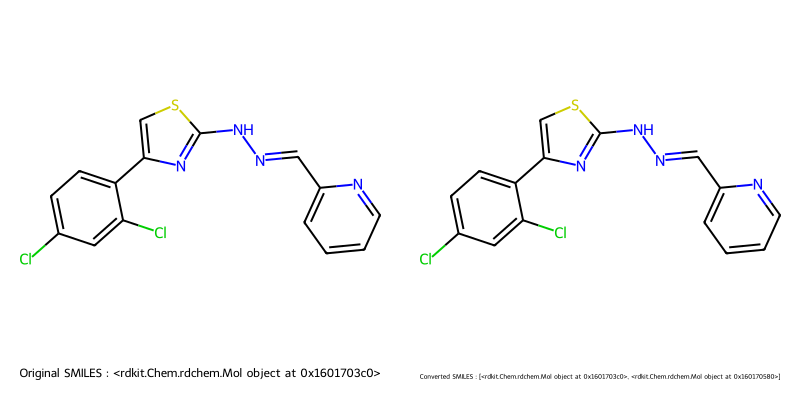

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [32]:
def display_molecule_3d(smiles,smiles2):
    # Create a molecule from SMILES
    mol = Chem.MolFromSmiles(smiles)
    mol2 = Chem.MolFromSmiles(smiles2)
    # Generate 3D coordinates
    # Create a list of molecules (original and converted)
    mols = [mol, mol2]

    # Create legends for molecules
    legends = [f"Original SMILES : {mol}", f"Converted SMILES : {mols}"]

    # Visualize the molecules side by side
    img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(400, 400), legends=legends)

    # Display the image
    display(img)

    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, randomSeed=42)
    AllChem.MMFFOptimizeMolecule(mol)
    
    mol2 = Chem.AddHs(mol2)
    AllChem.EmbedMolecule(mol2, randomSeed=42)
    AllChem.MMFFOptimizeMolecule(mol2)
    
    # Convert to PDB format
    pdb = Chem.MolToPDBBlock(mol)
    pdb2 = Chem.MolToPDBBlock(mol2)
    # Create py3Dmol view
    view1 = py3Dmol.view(width=600, height=400)
    view1.addModel(pdb, 'pdb')
    view1.setStyle({'stick': {}})
    view1.zoomTo()

    view2 = py3Dmol.view(width=600, height=400)
    view2.addModel(pdb2, 'pdb')
    view2.setStyle({'stick': {}})
    view2.zoomTo()
    
    # Display the 3D model
    display(view1)
    display(view2)

# Sample usage
smiles = "Clc1ccc(-c2csc(NN=Cc3ccccn3)n2)c(Cl)c1" 
smiles2= "Clc1ccc(-c2csc(N/N=C/c3ccccn3)n2)c(Cl)c1"
display_molecule_3d(smiles,smiles2)

#### Descriptive Statistics of Converted SMILES strings
***

In [4]:
def calculate_tanimoto_similarity(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    
    if mol1 is None or mol2 is None:
        return None
    
    # Generate Morgan fingerprints
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2, nBits=2048)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2, nBits=2048)
    
    return DataStructs.TanimotoSimilarity(fp1, fp2)

def compare_canonical_smiles(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    
    if mol1 is None or mol2 is None:
        return False
    
    return Chem.MolToSmiles(mol1, isomericSmiles=True, canonical=True) == \
           Chem.MolToSmiles(mol2, isomericSmiles=True, canonical=True)

In [5]:
# Calculate Tanimoto similarity
converted_df['Tanimoto_Similarity'] = converted_df.apply(
    lambda row: calculate_tanimoto_similarity(row['smiles'], row['Converted_SMILES']), 
    axis=1
)

[22:06:15] DEPRECATION WARNING: please use MorganGenerator
[22:06:15] DEPRECATION WARNING: please use MorganGenerator
[22:06:15] DEPRECATION WARNING: please use MorganGenerator
[22:06:15] DEPRECATION WARNING: please use MorganGenerator
[22:06:15] DEPRECATION WARNING: please use MorganGenerator
[22:06:15] DEPRECATION WARNING: please use MorganGenerator
[22:06:15] DEPRECATION WARNING: please use MorganGenerator
[22:06:15] DEPRECATION WARNING: please use MorganGenerator
[22:06:15] DEPRECATION WARNING: please use MorganGenerator
[22:06:15] DEPRECATION WARNING: please use MorganGenerator
[22:06:15] DEPRECATION WARNING: please use MorganGenerator
[22:06:15] DEPRECATION WARNING: please use MorganGenerator
[22:06:15] DEPRECATION WARNING: please use MorganGenerator
[22:06:15] DEPRECATION WARNING: please use MorganGenerator
[22:06:15] DEPRECATION WARNING: please use MorganGenerator
[22:06:15] DEPRECATION WARNING: please use MorganGenerator
[22:06:15] DEPRECATION WARNING: please use MorganGenerat

In [6]:
# Compare canonical SMILES
converted_df['Canonical_Match'] = converted_df.apply(
    lambda row: compare_canonical_smiles(row['smiles'], row['Converted_SMILES']), 
    axis=1
)

[22:06:50] SMILES Parse Error: syntax error while parsing: Invalid
[22:06:50] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[22:06:50] SMILES Parse Error: syntax error while parsing: Invalid
[22:06:50] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[22:06:50] SMILES Parse Error: syntax error while parsing: Invalid
[22:06:50] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[22:06:51] SMILES Parse Error: syntax error while parsing: Invalid
[22:06:51] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[22:06:51] SMILES Parse Error: syntax error while parsing: Invalid
[22:06:51] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[22:06:51] SMILES Parse Error: syntax error while parsing: Invalid
[22:06:51] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[22:06:51] SMILES Parse Error: syntax error while parsing: Invalid
[22:06:51] SMILES Parse Err

In [7]:
converted_df.head()

ChEMBL ID                                             smiles  \
0  CHEMBL3274216  Cn1nnnc1SCC1=C(C(=O)O)N2C(=O)C(NC(=O)C(N)c3ccc...   
1  CHEMBL3609212  O=c1c2ccccc2[nH]c2c(-c3c(-c4ccccc4O)[nH]c4cccc...   
2  CHEMBL2134582  CC1(C(=O)NS(=O)(=O)c2ccc(Cl)s2)CCN1C(=O)Cc1ccc...   
3  CHEMBL3958199      CCNc1ccc(Nc2ccc(OC(C)C)cc2)c(Cc2ccc(Cl)cc2)c1   
4  CHEMBL3894235  CCC#CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4ccc(Oc5cc...   

                                     FingerprintBits  \
0  [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                               SparseFingerprintBits  \
0  1 5 80 89 116 186 232 233 251 257 314 329 341 ...   
1  13 45 119 155 211 239 314 352 504 548 650 678 ...   
2  80 162 171 307 310 325 350 353 389 502 503 521...   
3  1 62 80 191 216 283 294 310 322 491 555 561 66...   
4  80 140 151 191 193 229 294 305 309 322 323 378...   

                                    Converted_SMILES  Tanimoto_Similarity  \
0  Cn1nnnc1SCC1=C(C(=O)O)N2C(=O)C(NC(=O)C(N)c3ccc...             1.000000   
1         O=c1c2ccccc2[nH]c2c(-c3ccccc3O)c3ccccc3n12             0.813953   
2  CC1(C(=O)NS(=O)(=O)c2ccc(Cl)s2)CCN1C(=O)Cc1ccc...             1.000000   
3      CCNc1ccc(Nc2ccc(OC(C)C)cc2)c(Cc2ccc(Cl)cc2)c1             1.000000   
4  CCC#CC(=O)N1CCC(C2CCNc3c(C(N)=O)c(-c4ccc(Oc5cc...             1.000000   

   Canonical_Match  
0            False  
1            False  
2             True  
3             True  
4             True

In [8]:
# Calculate average similarity
average_similarity = converted_df['Tanimoto_Similarity'].mean()
print(f"Average Tanimoto Similarity: {average_similarity}")

Average Tanimoto Similarity: 0.9766942630534936


In [9]:
# Count exact matches (similarity = 1.0)
tanimoto_matches = (converted_df['Tanimoto_Similarity'] == 1.0).sum()
canonical_matches = converted_df['Canonical_Match'].sum()
total_compounds = len(converted_df)

print(f"Tanimoto Accuracy: {tanimoto_matches / total_compounds:.2%}")
print(f"Canonical SMILES Accuracy: {canonical_matches / total_compounds:.2%}")

Tanimoto Accuracy: 89.46%
Canonical SMILES Accuracy: 66.59%


In [10]:
# Additional analysis
similarity_distribution = converted_df['Tanimoto_Similarity'].value_counts(normalize=True).sort_index()
print("\nTanimoto Similarity Distribution:")
print(similarity_distribution)


Tanimoto Similarity Distribution:
Tanimoto_Similarity
0.089286    0.000031
0.227273    0.000031
0.240741    0.000031
0.241935    0.000031
0.253165    0.000031
              ...   
0.982143    0.000031
0.982759    0.000031
0.983051    0.000031
0.983607    0.000031
1.000000    0.902479
Name: proportion, Length: 1001, dtype: float64


In [11]:
# Save results
converted_df.to_parquet("processed_data_with_similarity.parquet", index=False)
print("\nResults saved to 'processed_data_with_similarity.parquet'")


Results saved to 'processed_data_with_similarity.parquet'


##  Check for Molecular Collisions
***


In [39]:
# Load your data
df = pd.read_parquet("../data/molecule_fingerprints_combined.parquet")

morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

# Convert SparseFingerprintBits to a tuple for grouping
df['FingerprintTuple'] = df['SparseFingerprintBits'].apply(lambda x: tuple(map(int, x.split())))

# Group by fingerprint and count unique SMILES
collision_groups = df.groupby('FingerprintTuple').filter(lambda x: x['smiles'].nunique() > 1)

# Check if there are molecular collisions
if not collision_groups.empty:
    print(f"Found {len(collision_groups)} potential collisions.")
    
    for fingerprint, group in collision_groups.groupby('FingerprintTuple'):
        print("\nPotential collision:")
        print(f"Fingerprint: {fingerprint}")
        print("SMILES strings:")
        for _, row in group.iterrows():
            print(f"  {row['ChEMBL ID']}: {row['smiles']}")
        
        # Optionally, calculate and print Tanimoto similarity between the molecules
        mols = [Chem.MolFromSmiles(smiles) for smiles in group['smiles']]
        fps = [morgan_gen.GetFingerprint(mol) for mol in mols]
        
        print("Tanimoto similarities:")
        for i in range(len(mols)):
            for j in range(i+1, len(mols)):
                similarity = AllChem.DataStructs.TanimotoSimilarity(fps[i], fps[j])
                print(f"  {group['ChEMBL ID'].iloc[i]} vs {group['ChEMBL ID'].iloc[j]}: {similarity:.4f}")

else:
    print("No fingerprint collisions found in the dataset.")

Found 22 potential collisions.

Potential collision:
Fingerprint: (1, 80, 113, 202, 227, 294, 314, 591, 650, 656, 739, 745, 794, 807, 875, 1036, 1057, 1143, 1250, 1283, 1324, 1362, 1380, 1444, 1577, 1602, 1604, 1636, 1722, 1742, 1873, 1911, 1944, 2026)
SMILES strings:
  CHEMBL4281079: CCCCCCCC(O)c1oc(C)cc(=O)c1O
  CHEMBL4291711: CCCCCCC(O)c1oc(C)cc(=O)c1O
Tanimoto similarities:
  CHEMBL4281079 vs CHEMBL4291711: 1.0000

Potential collision:
Fingerprint: (2, 13, 45, 80, 95, 102, 213, 252, 289, 310, 322, 335, 351, 381, 533, 695, 718, 745, 802, 807, 852, 875, 896, 926, 935, 1028, 1034, 1057, 1145, 1160, 1239, 1313, 1357, 1380, 1411, 1422, 1452, 1480, 1482, 1602, 1683, 1722, 1750, 1754, 1765, 1778, 1791, 1832, 1873, 1998, 2018, 2021)
SMILES strings:
  CHEMBL46740: Cc1c(-c2ccc(O)cc2)n(Cc2ccc(OCCN3CCCCCC3)cc2)c2ccc(O)cc12
  CHEMBL44426: Cc1c(-c2ccc(O)cc2)n(Cc2ccc(OCCN3CCCCC3)cc2)c2ccc(O)cc12
Tanimoto similarities:
  CHEMBL46740 vs CHEMBL44426: 1.0000

Potential collision:
Fingerprint: (2, 13,

In [ ]:
smiles = "CCCCCCCC(O)c1oc(C)cc(=O)c1O" 
smiles2= "CCCCCCC(O)c1oc(C)cc(=O)c1O"
display_molecule_3d(smiles,smiles2)

In [44]:
for fingerprint, group in collision_groups.groupby('FingerprintTuple'):
    print(f"\nCollision for fingerprint: {fingerprint}")
    for _, row in group.iterrows():
        print(f"ChEMBL ID: {row['ChEMBL ID']}, SMILES: {row['smiles']}")
        
    # Analyze structural similarities
    mols = [Chem.MolFromSmiles(smiles) for smiles in group['smiles']]
    print("Structural analysis:")
    for mol in mols:
        print(f"Atoms: {mol.GetNumAtoms()}, Bonds: {mol.GetNumBonds()}")


Collision for fingerprint: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,